# Uncertainty of Recurrent Neural Network model with dropout at predict time
In recurrent networks, a parameter is used to determining whether dropout should be turned on or off at prediction time. If turned off, the model will automatically compute a mean value of predictions. This is typically the most robust approach if uncertainty analysis is not your main objective.

However, if dropout is turned on during prediction, we are able to perform individual predictions and explore the randomness of the model. In this case, a number of N predictions are typically made, from which statistical measurements such as mean and standard deviation can be found.

In [1]:
# %load predict_with_uncertainty.py
import src.core as mlApi
import src.core_configs as configs

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def plotDropoutPrediction(modelList, predictions, means, stds):
	global df_test

	for i in range(len(modelList)):
		output_mean = means[i]
		output_std = stds[i]

		for j in range(output_mean.shape[-1]):
			mean = output_mean[:, j]
			std = output_std[:, j]

			upper = np.add(mean, std)
			lower = np.subtract(mean, std)

			fig, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100)
			ax.set_xlabel('Date')
			ax.set_ylabel(mlApi._columnUnits[targetColumns[j]])
			ax.set_title(modelList[i].name + "\nPredictions and targets, " + mlApi._columnDescriptions[targetColumns[j]])
			ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, y_test[mlApi._maxEnrolWindow:, j], color="red", alpha=0.5, label="targets")
			ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, upper, color="grey", alpha=0.7, label="+/- 1 std bounds")
			ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, lower, color="grey", alpha=0.7)
			ax.plot(df_test.iloc[mlApi._maxEnrolWindow:].index, mean, color="blue", alpha=1.0, label="prediction")
			ax.grid(1, axis='y')
			ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., prop={'size': 10})
			
			plt.show()

Columns before removal: 
Col. 0 : FYN0111 - Gasseksport rate
Col. 1 : TT0102_MA_Y - Varm side A temperatur inn
Col. 2 : TIC0101_CA_YX - Varm side A temperatur ut
Col. 3 : TT0104_MA_Y - Varm side B temperatur inn
Col. 4 : TIC0103_CA_YX - Varm side B temperatur ut
Col. 5 : TT0106_MA_Y - Varm side C temperatur inn
Col. 6 : TIC0105_CA_YX - Varm side C temperatur ut
Col. 7 : PDT0108_MA_Y - Varm side A trykkfall
Col. 8 : PDT0119_MA_Y - Varm side B trykkfall
Col. 9 : PDT0118_MA_Y - Varm side C trykkfall
Col. 10 : PIC0104_CA_YX - Innløpsseparator trykk
Col. 11 : TIC0425_CA_YX - Kald side temperatur inn
Col. 12 : TT0651_MA_Y - Kald side A temperatur ut
Col. 13 : TT0652_MA_Y - Kald side B temperatur ut
Col. 14 : TT0653_MA_Y - Kald side C temperatur ut
Col. 15 : TIC0101_CA_Y - Kald side A ventilåpning
Col. 16 : TIC0103_CA_Y - Kald side B ventilåpning
Col. 17 : TIC0105_CA_Y - Kald side C ventilåpning

Columns after removal: 
Col. 0 : FYN0111 - Gasseksport rate
Col. 1 : TT0106_MA_Y - Varm side C te

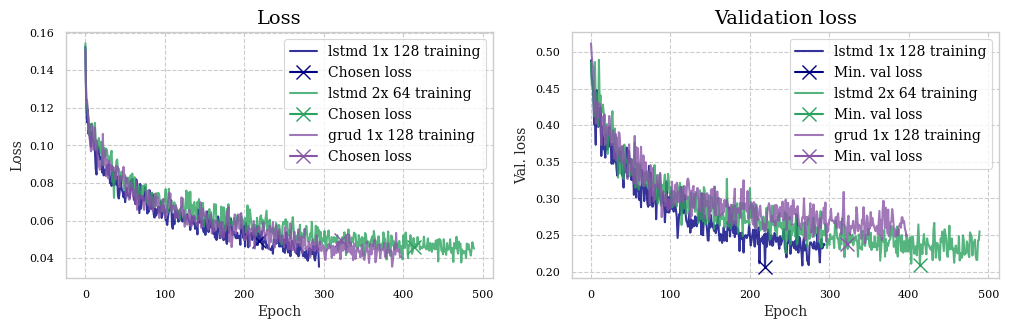

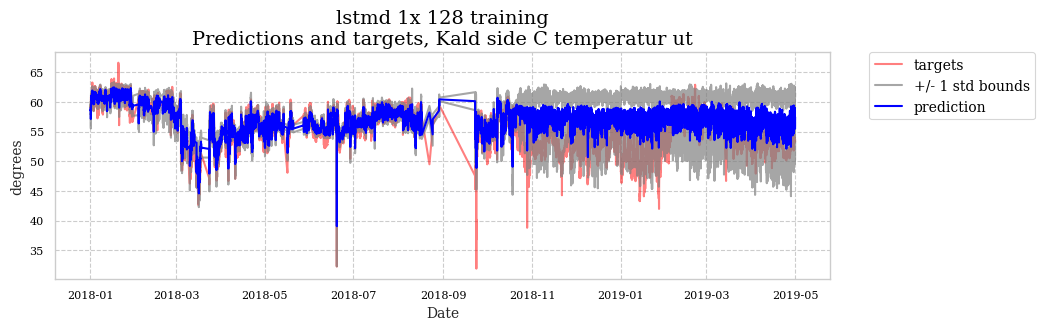

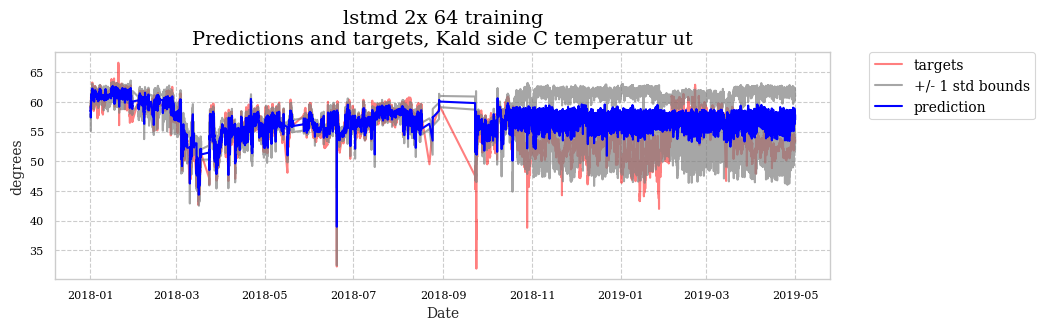

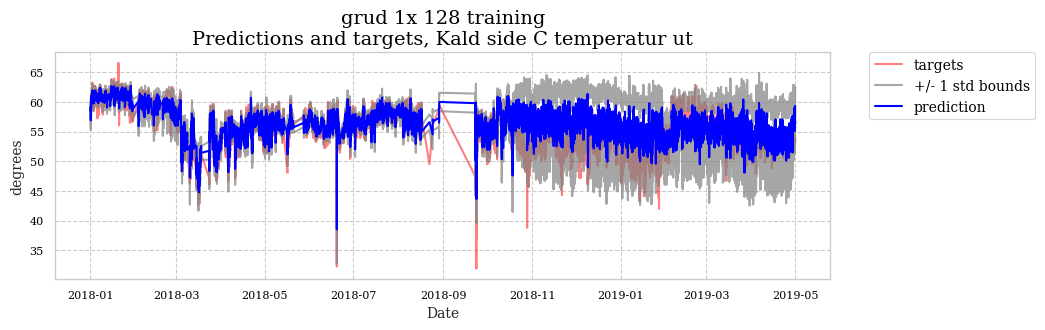

In [3]:
# 1. Define dataset specifics
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('F', 'B', '30min')

# 2. Initiate and divide data
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models | NB: only RNN (LSTM/GRU) models
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

# 4. Initiate and train models
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

# 5. Predict
predictions, means, stds = mlApi.predictWithModelsUsingDropout(numberOfPredictions=30)

plotDropoutPrediction(modelList, predictions, means, stds)

In [4]:
mlApi.reset()

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : TI0066 - Process side Temperature out
Col. 1 : TZI0012 - Process side Temperature in
Col. 2 : FI0010 - Process side flow rate
Col. 3 : TT0025 - Cooling side Temperature in
Col. 4 : TT0026 - Cooling side Temperature out

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 4708 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 49290 rows

Model lstmd 1x 128 training was loaded from file
Model lstmd 2x 64 training was loaded from file
Model grud 1x 128 training was

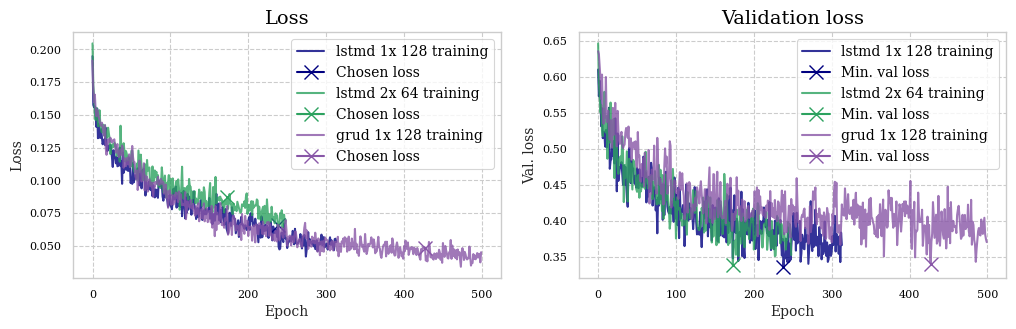

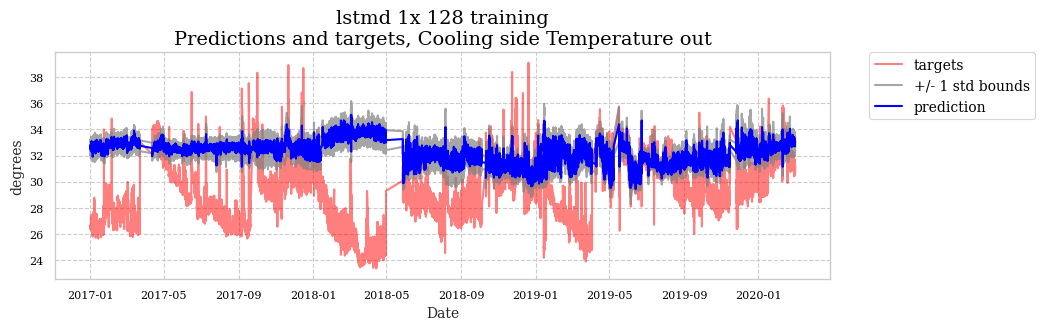

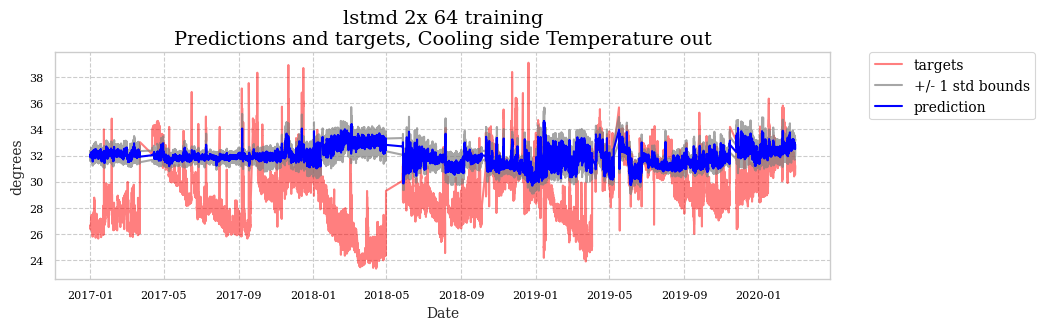

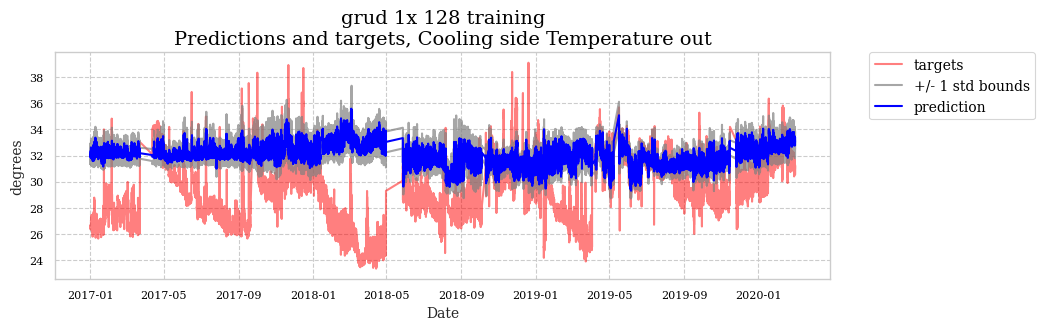

In [5]:
# 1. Define dataset specifics
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('G', 'A', '30min')

# 2. Initiate and divide data
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models | NB: only RNN (LSTM/GRU) models
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

# 4. Initiate and train models
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

# 5. Predict
predictions, means, stds = mlApi.predictWithModelsUsingDropout(numberOfPredictions=30)

plotDropoutPrediction(modelList, predictions, means, stds)

In [6]:
mlApi.reset()

Columns before removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out
Col. 6 : PI0001 - Cooling side Pressure in
Col. 7 : FI0027 - Cooling side flow rate
Col. 8 : TIC0022U - Cooling side valve opening
Col. 9 : PDT0024 - Cooling side dP

Columns after removal: 
Col. 0 : PDI0064 - Process side dP
Col. 1 : TI0066 - Process side Temperature out
Col. 2 : TZI0012 - Process side Temperature in
Col. 3 : FI0010 - Process side flow rate
Col. 4 : TT0025 - Cooling side Temperature in
Col. 5 : TT0026 - Cooling side Temperature out

Finding data between 2019-04-10 00:00:00 and 2019-08-01 00:00:00
Found 13885 rows

Finding data between 2017-01-01 00:00:00 and 2020-03-01 00:00:00
Found 146747 rows

Model lstmd 1x 128 training was loaded from file
Model lstmd 2x 64 training was loaded fro

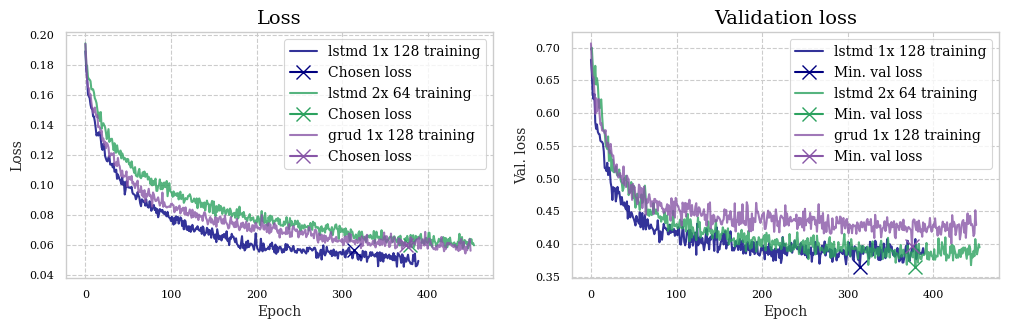

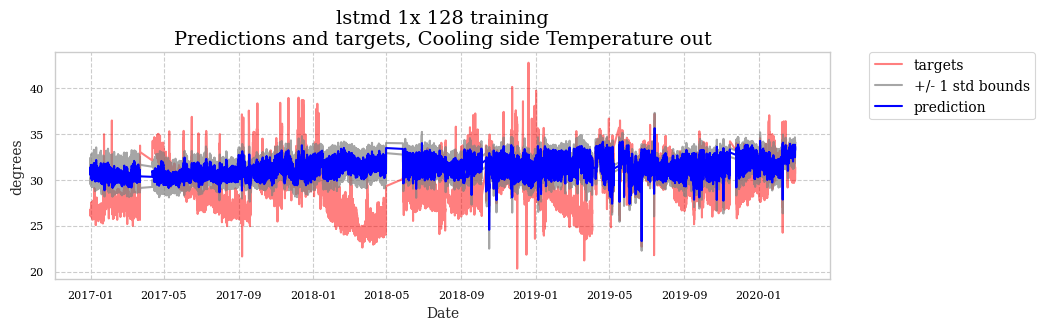

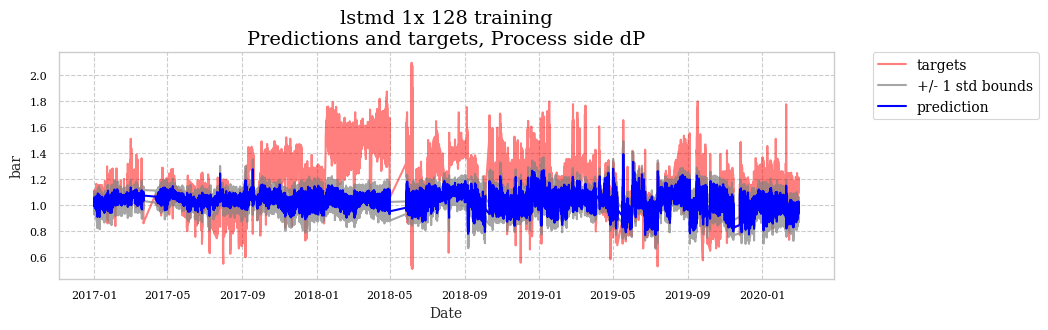

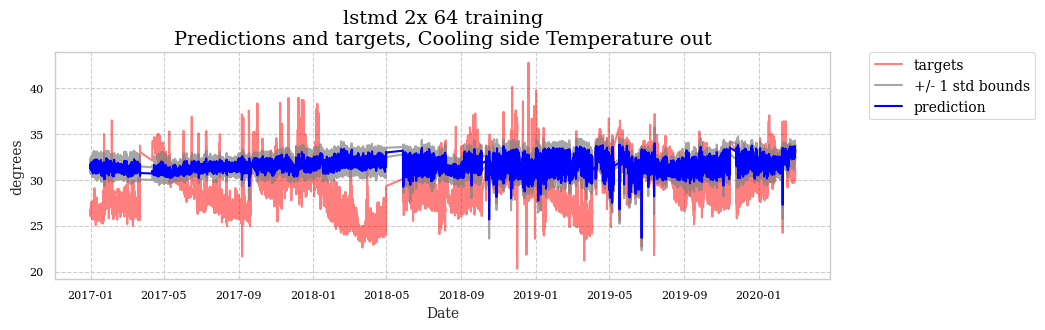

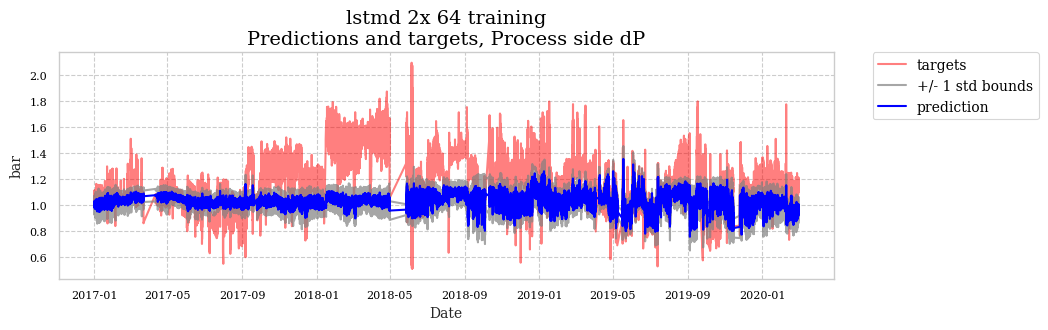

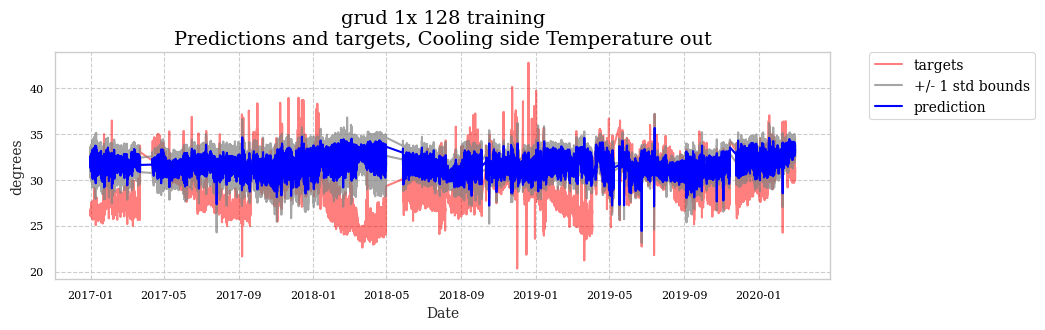

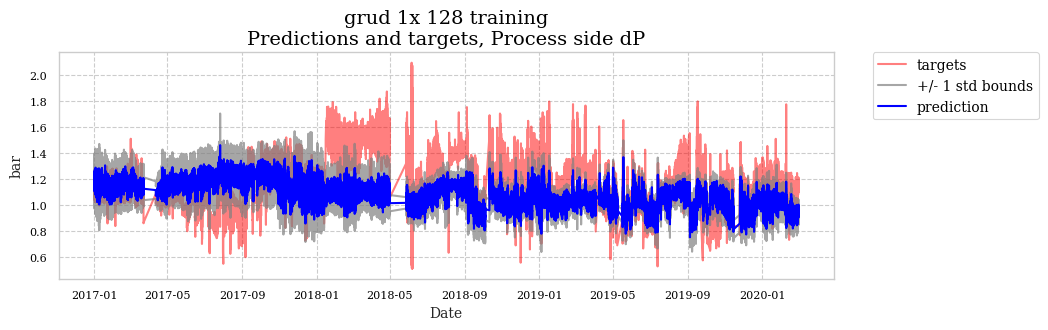

In [7]:
# 1. Define dataset specifics
filename, columns, irrelevantColumns, targetColumns, traintime, testtime, columnOrder = configs.getConfig('G', 'C', '10min')

# 2. Initiate and divide data
df = mlApi.initDataframe(filename, columns, irrelevantColumns)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

# 3. Define models | NB: only RNN (LSTM/GRU) models
lstmd_1x_128 = mlApi.LSTM('lstmd 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
lstmd_2x_64 = mlApi.LSTM('lstmd 2x 64 training', layers=[64, 64], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)
gru_1x_128 = mlApi.GRU('grud 1x 128 training', layers=[128], dropout=0.2, recurrentDropout=0.2, training=True, epochs=500, enrolWindow=12)

modelList = [
	lstmd_1x_128,
	lstmd_2x_64,
	gru_1x_128,
]

# 4. Initiate and train models
retrain=False
mlApi.initModels(modelList)
mlApi.trainModels(retrain)

# 5. Predict
predictions, means, stds = mlApi.predictWithModelsUsingDropout(numberOfPredictions=30)

plotDropoutPrediction(modelList, predictions, means, stds)

The results are not discussed in detail here, as the purpose of this notebook is to describe the process of predicting with uncertainty. Even so, it should be noted that the GRU model does not seem to generalize to the testing data very well. This may come as a surprise considering the model itself has converged for the training data with only slightly higher validation loss than the LSTM model. Predictions for this model are in general not in line with what is expected, and the uncertainty of the model is large. The LSTM model is assumed to give a more realistic fouling indicator.